# Scrip U-Net

Here we have a first aproach to an easy U-Net model. First we are going to build the model, second we show an example of how to load and preprocess the data and use it to train the model and finally we use a pretrained weights to perform inference.

First of all we import the required libraries.

In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
#from sklearn.metrics import jaccard_score

# This is in order to specify the use of the GPU. Use "-1" for no GPU use, "" for use all the GPU's and "number" to select one GPU to be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Create the U-Net model

First we define some functions to build the model and then we build it with the specified input shape and the desired number of classes.

In [2]:
def conv_block(inputs, filters, pool = True):
    ''' Define a convolutional block of the encoder.
  
    Arguments:
        - inputs (tf tensor): Input tensor
        - filters (int): Number of filters
        - pool (bool): Do the MaxPooling or not -- True

    Returns:
        - x (tf tensor): Output tensor before the MaxPooling
        - p (tf tensor): Output tensor after the MaxPooling '''

    x = tf.keras.layers.Conv2D(filters, 3, padding = "same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(filters, 3, padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    if pool == True:
        p = tf.keras.layers.MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x


def build_unet(shape, num_classes):
    ''' Build an UNET form model with GDN.
  
    Arguments:
        - shape ((int, int, int)): Shape of the input tensor
        - num_classes (int): Number of classes

    Returns:
        - model (tf model): Model built '''

    inputs = tf.keras.Input(shape)

    # Encoder
    x1, p1 = conv_block(inputs, 16, pool = True)
    x2, p2 = conv_block(p1, 32, pool = True)
    x3, p3 = conv_block(p2, 64, pool = True)
    x4, p4 = conv_block(p3, 128, pool = True)

    b1 = conv_block(p4, 256, pool = False)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(256, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(b1)
    c1 = tf.keras.layers.Concatenate()([u1, x4])
    x5 = conv_block(c1, 128, pool = False)

    u2 = tf.keras.layers.Conv2DTranspose(128, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x5)
    c2 = tf.keras.layers.Concatenate()([u2, x3])
    x6 = conv_block(c2, 64, pool = False)

    u3 = tf.keras.layers.Conv2DTranspose(64, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x6)
    c3 = tf.keras.layers.Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool = False)

    u4 = tf.keras.layers.Conv2DTranspose(32, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x7)
    c4 = tf.keras.layers.Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool = False)

    # Output
    output = tf.keras.layers.Conv2D(num_classes, 1, padding = 'same', activation = 'softmax')(x8)

    return tf.keras.Model(inputs, output)

In [3]:
img_height, img_width, channels = 96, 256, 3
num_classes = 30

model = build_unet((img_height, img_width, channels), num_classes)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 256, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 256, 16)  448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 256, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Load and preprocess the data

Now that we have built the model we have to load and preprocess the data we will use to train the model.We use the Cityscapes database (German city images segmented with 30 classes): https://www.cityscapes-dataset.com/

First we define some function to load and preprocess the images and the ground truths and then we build the tensorflow datasets.

In [4]:
def one_hot_mask(y):
    ''' Do the one hot encoding for the masks.
  
    Arguments:
        - y (tf tensor): Mask of shape (height, width, 3)

    Returns:
        - mask (tf tensor): Mask after do the one hot. Shape (height, width, num_classes) '''

    one_hot_map = []
    for color in colors:
        class_map = tf.reduce_all(tf.equal(y, color), axis = -1)
        one_hot_map.append(class_map)
    mask = tf.cast(tf.stack(one_hot_map, axis = -1), tf.int32)
    return mask


def load_image(folder, file, height = 96, width = 256, crop = True):
    ''' Load and preprocess a train image by:
        - Crop the image to not have the Mercedes-Benz star
        - Resize the image to (height, width)
        - Normalize the image to [0, 1]
  
    Arguments:
        - folder (string): Path to the folder
        - file (string): Name of the file to load
        - height (int): Height to resize -- 96
        - width (int): Width to resize -- 256
        - crop (bool): Crpo the image or not -- True

    Returns:
        - image (tf tensor): Preprocessed image '''

    # Load the image (png)
    image = tf.io.read_file(folder + '/' + file)
    image = tf.cast(tf.image.decode_png(image, channels = 3), tf.float32)

    # Crop the image
    if crop:
        image = tf.image.crop_to_bounding_box(image, 0, 0, 768, 2048)

    # Resize the image
    image = tf.image.resize(image, (height, width))

    # Normalize the image
    image = tf.cast(image, tf.float32)/255.0
    return image


def load_mask(folder, file, height = 96, width = 256, one_hot = True, crop = True):
    ''' Load and preprocess a train mask by:
        - Crop the image to not have the Mercedes-Benz star
        - Resize the image to (height, width)
        - Reshaping the mask from (height, width, 3) to (height, width, 30): One hot encoding
  
    Arguments:
        - folder (string): Path to the folder
        - file (string): Name of the file to load
        - height (int): Height to resize -- 96
        - width (int): Width to resize -- 256
        - one_hot (bool): Do one hot encoding or not -- True
        - crop (bool): Crpo the image or not -- True

    Returns:
        - image (tf tensor): Preprocessed mask '''

    # Load the mask (png)
    image = tf.io.read_file(folder + '/' + file)
    image = tf.cast(tf.image.decode_png(image, channels = 3), tf.int32)

    # Crop the mask
    if crop:
        image = tf.image.crop_to_bounding_box(image, 0, 0, 768, 2048)

    # Resize the mask
    image = tf.image.resize(image, (height, width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # One hot encoding
    if one_hot:
        image = one_hot_mask(image)
    return image


def load_train(image_name, mask_name):
    ''' Load and preprocess a train image and its mask
  
    Arguments:
        - image_name (string): Name of the image to load
        - mask_name (string): Name of the mask to load

    Returns:
        - image (tf tensor): Preprocessed image
        - mask (tf tensor): Preprocessed mask '''

    image = load_image(train_images_folder_path, image_name, img_height, img_width)
    mask = load_mask(train_mask_folder_path, mask_name, img_height, img_width)
    return image, mask


def load_test(image_name, mask_name):
    ''' Load and preprocess a validation image and its mask
  
    Arguments:
        - image_name (string): Name of the image to load
        - mask_name (string): Name of the mask to load

    Returns:
        - image (tf tensor): Preprocessed image
        - mask (tf tensor): Preprocessed mask '''

    image = load_image(test_images_folder_path, image_name, img_height, img_width)
    mask = load_mask(test_mask_folder_path, mask_name, img_height, img_width)
    return image, mask

We need the ground truth color information to do the one-hot encoding.

In [5]:
names = ['unlabeled', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall',
         'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
         'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']

colors = np.array([(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), (102, 102, 156), (190, 153, 153), (180, 165, 180), 
                   (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), ( 0, 0, 142), 
                   ( 0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), (119, 11, 32), (0, 0, 142)], dtype = np.int32)

We get the image names.

In [ ]:
train_images_folder_path = "./Data/Train_data/Images" 
train_mask_folder_path = "./Data/Train_data/Labels" 
test_images_folder_path = "./Data/Validation_data/Images" 
test_mask_folder_path = "./Data/Validation_data/Labels" 

train_images_names_original = sorted([img for img in os.listdir(train_images_folder_path) if img.endswith('bit.png')])
train_mask_names_original = sorted([img for img in os.listdir(train_mask_folder_path) if img.endswith('.png')])

test_images_names = sorted([img for img in os.listdir(test_images_folder_path) if img.endswith('bit.png')])
test_mask_names = sorted([img for img in os.listdir(test_mask_folder_path) if img.endswith('.png')])

print(f'Train images: ', len(train_images_names_original), ' Train ground truth images: ', len(train_mask_names_original))
print(f'Train images: ', len(test_images_names), ' Train ground truth images: ', len(test_mask_names))

FileNotFoundError: ignored

Now we select 300 random images from train to use them as validation images and reorder the train images.

In [ ]:
validation_values = random.sample(range(len(train_images_names_original)), 300)
train_values = random.sample(list(set(range(len(train_images_names_original))) - set(validation_values)), len(train_images_names_original) - 300)

train_images_names, train_mask_names = [train_images_names_original[j] for j in train_values], [train_mask_names_original[j] for j in train_values]
val_images_names, val_mask_names = [train_images_names_original[j] for j in validation_values], [train_mask_names_original[j] for j in validation_values]

print(f'Train images: ', len(train_images_names), ' Train ground truth images: ', len(train_mask_names))
print(f'Validation images: ', len(val_images_names), ' Validation ground truth images: ', len(val_mask_names))
print(f'Train images: ', len(test_images_names), ' Train ground truth images: ', len(test_mask_names))

Train images:  2675  Train ground truth images:  2675
Validation images:  300  Validation ground truth images:  300
Train images:  500  Train ground truth images:  500


Now we build the tensorflow datasets.

In [ ]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_images_names, train_mask_names))
train_dataset = train_dataset.map(load_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
print(train_dataset)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images_names, val_mask_names))
val_dataset = val_dataset.map(load_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
print(val_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images_names, test_mask_names))
test_dataset = test_dataset.map(load_test, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 96, 256, 3), (None, 96, 256, 30)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 96, 256, 3), (None, 96, 256, 30)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 96, 256, 3), (None, 96, 256, 30)), types: (tf.float32, tf.int32)>


We can visualize some of the images.

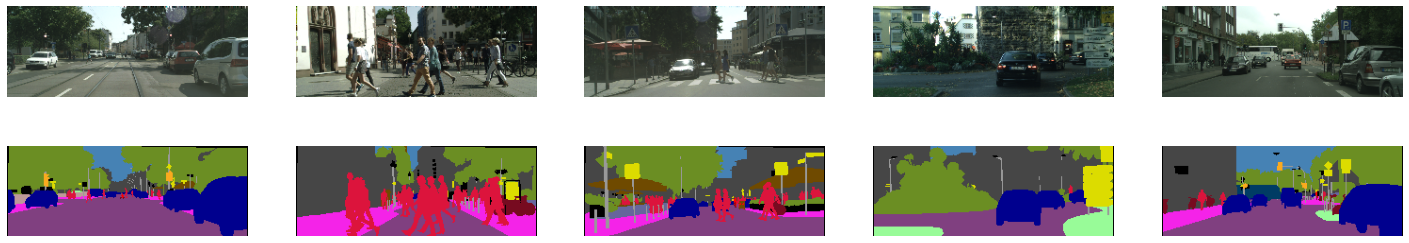

In [ ]:
idx = [3, 80, 194, 281, 406]
visualize_images = [load_image(test_images_folder_path, test_images_names[i], img_height, img_width) for i in idx]
visualize_masks = [load_mask(test_mask_folder_path, test_mask_names[i], img_height, img_width, one_hot = False) for i in idx]

plt.figure(figsize = (25, 5))
plt.subplots_adjust(hspace = 0.05)

for k in range(len(idx)):
    plt.subplot(2, 5, k + 1)
    plt.imshow(visualize_images[k])
    plt.axis('off')
    plt.subplot(2, 5, k + 6)
    plt.imshow(visualize_masks[k])
    plt.axis('off')
plt.show()

## Train the model

Now that we have the datasets and the model we can train it. The standard metric for segmentation is the IoU (intersection over union), so we first create a callback to calculate it after each epoch and save the weights if the validation IoU is higher than the previous ones.

In [ ]:
def iou_metrics(y_true, y_pred):
    ''' Calculate the intersection over union metric for each class for one image.
  
    Arguments:
        - y_true (array): Real mask with one hot (height, width, 30)
        - y_pred (array): Predicted mask the classes with highest probabilities (height, width, 1)

    Returns:
        - class_iou (float): Mean weighted IoU '''
    
    iou = []
    for pred in range(y_pred.shape[0]):
        one_hot_map = []
        for clas in range(len(colors)):
            class_map = tf.reduce_all(tf.equal(y_pred[pred].reshape(img_height, img_width, 1), clas), axis = -1)
            one_hot_map.append(class_map)
        pred_i = np.array(tf.cast(tf.stack(one_hot_map, axis = -1), tf.int32))
        iou.append(jaccard_score(y_true[pred].reshape(img_height*img_width, num_classes), pred_i.reshape(img_height*img_width, num_classes), average = 'samples'))

    return np.mean(iou)


class JaccardScoreCallback(tf.keras.callbacks.Callback):
    """Computes the Jaccard score and logs the results to TensorBoard."""

    def __init__(self, model, y_val, val_dataset):
        self.model = model
        self.y_validation = y_val
        self.validation_dataset = val_dataset
        self.epoch = 0
        self.best_iou = 0.0

    def on_epoch_end(self, batch, logs = None):
        self.epoch += 1
        predictions = self.model.predict(self.validation_dataset)
        predictions = np.argmax(predictions, axis = 3)
        jaccard_value = iou_metrics(self.y_validation, predictions)
        ious.append(np.array(jaccard_value))
        if jaccard_value > self.best_iou:
          self.best_iou = jaccard_value
          self.model.save_weights('./Segmentation/best_model.h5', overwrite = True)
        print('IoU on validation: ', jaccard_value)

We train the model.

In [ ]:
init_lr = 1e-3
epochs = 500

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', 
                                                 factor = 0.5,
                                                 patience = 15,
                                                 min_delta = 0.001, 
                                                 min_lr = 1e-12,
                                                 verbose = 1)

ious = []
y_val = np.array([load_mask(train_mask_folder_path, val_name, img_height, img_width, one_hot = True) for val_name in val_mask_names])
callback_iou = JaccardScoreCallback(model, y_val, val_dataset)

model.compile(loss = 'mae',    
              optimizer = tf.keras.optimizers.Adam(learning_rate = init_lr), 
              metrics = ['accuracy'])

train_history = model.fit(train_dataset, 
                          epochs = epochs,
                          verbose = 2,
                          callbacks = [callback_iou, reduce_lr],
                          validation_data = val_dataset)

We can visualize the training curves.

In [ ]:
plt.plot(np.log10(train_history.history['lr']))
plt.grid()
plt.title('Model learning rate')
plt.ylabel('Log10(lr)')
plt.xlabel('Epoch')
plt.show()

plt.plot(train_history.history['accuracy'], label = 'Train')
plt.plot(train_history.history['val_accuracy'], label = 'Validation')
plt.grid()
plt.legend()
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(train_history.history['loss'], label = 'Train')
plt.plot(train_history.history['val_loss'], label = 'Validation')
plt.grid()
plt.legend()
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(ious)
plt.grid()
plt.title('Model validation IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.show()

## Restore weights and do inference

FInally we can load some pre-trained weights and after that do inference.

In [ ]:
model.load_weights('./Segmentation/best_model.h5')

predictions = model.predict(test_dataset, batch_size = 32)
predictions = np.argmax(predictions, axis = 3)

Then we can visualize some of the predictions with the original image and the ground truth.

In [ ]:
def one_hot_to_color_mask(mask, colors, img_height = 96, img_width = 256):
    ''' Convert from the mask from the classes with highest probablities to the correct color. From (96, 256, 1) to (96, 256, 3).
  
    Arguments:
        - mask (tf tensor): Mask with the classes with highest probabilities
        - colors (list): List with the class colors
        - img_height (int): Height of the images -- 96
        - img_width (int): Width of the images -- 256

    Returns:
        - color_mask (tf tensor): Color mask '''

    color_mask = np.zeros((img_height, img_width, channels)).astype('float')
    for c in range(len(colors)):
        color_true = mask == c
        for i in range(3):
            color_mask[:,:,i] += color_true*colors[c][i]

    color_mask = tf.cast(color_mask, dtype = tf.int32)

    return color_mask


idx = [3, 80, 194, 281, 406]
visualize_images = [load_image(test_images_folder_path, test_images_names[i], img_height, img_width) for i in idx]
visualize_masks = [load_mask(test_mask_folder_path, test_mask_names[i], img_height, img_width, one_hot = False) for i in idx]
preds = predictions[idx]

plt.figure(figsize = (25, 5))
plt.subplots_adjust(hspace = 0.05)

for k in range(len(idx)):
    plt.subplot(3, 5, k + 1)
    plt.imshow(visualize_images[k])
    plt.axis('off')
    plt.subplot(3, 5, k + 6)
    plt.imshow(visualize_masks[k])
    plt.axis('off')
    plt.subplot(3, 5, k + 6)
    plt.imshow(one_hot_to_color_mask(preds[k], colors))
    plt.axis('off')
plt.show()